In [1]:
import sys
sys.path.append('..')

import cvxopt
import numpy as np
import matplotlib.pyplot as plt

import metrics

# Introduction

The predictor $G(X)$ takes values in a discrete set $\mathbb{G}$. The input space is divided into a collection regions labeled according to their clasification.  
The boundaries of these regions are called decisions boundaries, and they are linear for linear methods

## Example 1

Example of $K$ classes with discriminant function:

$$\delta_k(x) = \beta_{k0} + \beta_k^Tx$$
The assigned class is the one with the biggest value for $\delta_k$.  

The decision boundary between class $k$ and $l$ is the set of points for wich $\delta_k(x) = \delta_l(x)$.  
That is the hyperplane defined by $\{x: (\beta_{k0} - \beta_{l0}) + (\beta_k - \beta_l)^Tx = 0 \}$.

Methods that model the posterior probabilities $P(G = k | X = x)$ are also in this class.  
If $\delta_k(x)$ or $P(G = k | X = x)$ is linear in $x$, then the decision boundaries will be linear.

## Example 2

Example of 2 classes with posterior probabilities:
    
$$P(G = 1 | X = x) = \frac{\exp(\beta_0 + \beta^Tx)}{1 + \exp(\beta_0 + \beta^Tx)}$$
$$P(G = 2 | X = x) = \frac{1}{1 + \exp(\beta_0 + \beta^Tx)}$$  

The decision boundary is the set of points for which the log-odds are zero:

$$\log(\frac{p}{1-p}) = 0$$
$$\log \frac{P(G = 1 | X = x)}{P(G = 2 | X = x)} = \beta_0 + \beta^Tx$$

Thus the decision boundary is an hyperplane defined by $\{x | \beta_0 + \beta^Tx = 0\}$.  

Linear logistic regression and linear discriminant analysis have linear log-odds.

Another solution is to explicitely model linear boundaries between the classes.

# Linear Regression of an Indicator Matrix

The output is a vector $y \in \mathbb{R}^{K}$, with $K$ the number of classes.
If the example belong to classs $k$, $y_j = 1_{j=k}$.  
For a training set of size $N$, the output matrix is $Y \in \mathbb{R}^{N*K}$.  

The parameters are fitted using any multiple outputs linear classification methods for $X$ and $Y$, eg normal equations:
$$\hat{B} = (X^TX)^{-1} X^TY$$.  

Classify an example:
$$\hat{y} = x^T \hat{B}$$
$$\hat{G}(x) = \arg \max_{k \in \mathbb{G}} \hat{y}_k$$

Regression gives an expectation of conditional expectation.
$$y_k = \mathbb{E}(y_k | X = x) = P(G = k | X = x)$$

In [2]:
def gen_toy_class(N, noise=0.001):
    X = 2.8 * np.random.randn(N, 4)**1 + 4.67
    v1 = 1.5*X[:, 0] + 2.3*X[:, 1] - 0.3*X[:, 2] + 4.5 + noise*np.random.randn(len(X)) 
    v2 = 1.7*X[:, 0] + 0.4*X[:, 1] + 2.3*X[:, 2] - 3.7 + noise*np.random.randn(len(X))
    v3 = -0.6*X[:, 0] + 5.8*X[:, 1] - 1.3*X[:, 2] + 0.1 + noise*np.random.randn(len(X))
    V = np.vstack((v1, v2, v3)).T
    g = np.argmax(V, axis=1)
    return X, g

def label2onehot(g, nclasses):
    Y = np.zeros((len(g), nclasses))
    Y[np.arange(len(g)), g] = 1
    return Y

def onehot2labels(Y):
    return np.argmax(Y, axis=1)

def add_col1(X):
    return np.append(np.ones((len(X),1)), X, axis=1)

In [3]:
#Example with 3 classes

X, g = gen_toy_class(117, noise=1e-3)
Y = label2onehot(g, 3)

X2 = add_col1(X)
B = np.linalg.inv(X2.T @ X2) @ X2.T @ Y

Y_preds = X2 @ B
preds = onehot2labels(Y_preds)
print('error:', np.mean((Y - Y_preds)**2))
print('acc:', np.mean(g == preds))

error: 0.11774561236065781
acc: 0.8034188034188035


In [4]:
def gen_toy_bin(N, noise=0.001):
    X = 2.8 * np.random.randn(100000, 4)**2 + 4.67
    v = 1.5*X[:, 0] + 2.3*X[:, 1] - 4.7*X[:, 2] + 4.5 + noise*np.random.randn(len(X))
    m = v.mean()
    X = X[:N]
    g = (v[:N] > m).astype(np.int)
    return X, g

In [5]:
#Binary example

X, g = gen_toy_bin(117000, noise=0)
Y = label2onehot(g, 2)

X2 = add_col1(X)
B = np.linalg.inv(X2.T @ X2) @ X2.T @ Y

Y_preds = X2 @ B
preds = onehot2labels(Y_preds)
print('error:', np.mean((Y - Y_preds)**2))
print('acc:', np.mean(g == preds))

error: 0.12378969687163588
acc: 0.8524


$y_k$ doesn't belong like a probability. Even though $\sum_{k \in \mathbb{G}} y_k = 1$, $y_k$ might be negative or greater than $1$.

Another approch is to construct a target $t_k$ for each class, with $t_k$ $k$-th columns of $I_K$.
Obervations are $y_i = t_k$ if $g_i = k$.
We fit the least-squares criterion:
$$\hat{B} = \arg \min_{B} \sum_{i=1}^N ||y_i - x_i^TB||^2$$

Classify an example:
$$\hat{G}(x) = \arg \min_{k} ||x_i^T\hat{B} - t_k||^2$$  

Actually, this model yields exactly the same results than the previous ones.

This model doesn't work well when $K \geq 3$. Because of the rigid nature of regression, classes can be masked by others.  
A general rule is that with $K \geq 3$ classes, polynomials terms up to degree $K - 1$ might be needed to solve them.  
Masking usually occurs for large $K$ and small $p$.  
Other methods like logistic regression and linear distriminant analysis doesn't suffer from masking

# Linear Discriminant Analysis

According to Bayes theorem:
    
$$P(G = k | X = x) = \frac{P(X = x | G = k) P(G = k)}{P(X)}$$
$$P(G = k | X = x) = \frac{P(X = x | G = k) P(G = k)}{\sum_{l=1}^K P(X = x | G = l) P(G = l)}$$

Let $\pi_k$ the prior probability of class $k$: $\pi_k = P(G = k)$.  
Let $f_k(x)$ the class-condisional density of $X$ in class $G = k$: $P(X \in T | G = k) = \int_T f_k(x)dx$.

Thus, the posterior probability is:

$$P(G = k | X = x) = \frac{f_k(x) \pi_k}{\sum_{l=1}^K f_l(x) \pi_l}$$

Each density class is represented as a multivariate Gaussian:

$$f_k(x) = \frac{\exp(-\frac{1}{2} (x-\mu_k)^T \Sigma^{-1} (x - \mu_k) )}{\sqrt{(2\pi)^p |\Sigma|}}$$

with:
- $\Sigma \in \mathbb{R}^{p*p}$ covariance matrix shared by all class densities.
- $\mu_k \in \mathbb{R}^p$ the mean vector for class density $k$.
- $|\Sigma| = \det(\Sigma)$  

$$\log \frac{P(G = k | X = x)}{P(G = l | X = x)} = \log \frac{\pi_k}{\pi_l} - \frac{1}{2}(\mu_k + \mu_l)^T\Sigma^{-1}(\mu_k - \mu_l) + x^T \Sigma^{-1}(\mu_k - \mu_l)$$.

The log-odds function is linear in $x$, so the decision boundaries are linear.

The decision rule can be described with linear descriminant functions:

$$\delta_k(x) = x^T \Sigma^{-1} \mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \log \pi_k$$
$$G(x) = \arg \max_k \delta_k(x)$$  

The parameters are estimated from the training data:
$$\hat{\pi}_k = \frac{N_k}{N}$$
$$\hat{\mu}_k = \frac{\sum_{g_i = k} x_i}{N_k}$$
$$\hat{\Sigma} = \frac{\sum_{k=1}^K \sum_{g_i = k} (x_i - \mu_k)(x_i - \mu_k)^T}{N - K}$$

In [6]:
#Example with 3 classes

def lda(X, g, K):
    N = X.shape[0]
    p = X.shape[1]
    
    pis = []
    mus = []
    cov = np.zeros((p, p))
    
    for k in range(K):
        nk = np.sum(g == k)        
        pi = nk / N
        mu = np.zeros((p,))
        for i in range(N):
            if g[i] == k:
                mu += X[i]
        mu /= nk
        
        pis.append(pi)
        mus.append(mu)
        
    
    for i in range(N):
        cov += np.outer(X[i] - mus[g[i]], X[i] - mus[g[i]])
    cov /= (N - K)
    
    
    icov = np.linalg.inv(cov)
    B = np.empty((p, K))
    intercept = np.empty((K,))
    for k in range(K):
        B[:, k] = icov @ mus[k]
        intercept[k] = - 1/2 * (mus[k] @ icov @ mus[k]) + np.log(pis[k])
    
    return B, intercept


X, g = gen_toy_class(11700, noise=1e-5)
B, intercept = lda(X, g, 3)

Y_preds = X @ B + intercept
preds = np.argmax(Y_preds, axis=1)

print('acc:', np.mean(g == preds))

acc: 0.9868376068376068


## Quadratic Discriminant Analysis

If each $f_k(x)$ as it's own covariance marix $\Sigma_k$, the logs-odd function and the distriminant functions became quadratic:

$$\delta_l(x) = - \frac{1}{2} \log | \Sigma_k| - \frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) + \log \pi_k$$  

When $p$ large, QDA causes a dramatic increase in the number of parameters.  
There is little difference between LDA applied to dataset augmented with polynomials of degree $2$, and QDA.  

For QDA, the estimates of $\pi_k$ and $u_k$ stays the same, and the estimate of $\Sigma_k$ is:

$$\hat{\Sigma}_k = \frac{\sum_{g_i = k} (x_i - \mu_k)(x_i - \mu_k)^T}{N_k - 1}$$

In [7]:
#Example with 3 classes

def qda(X, g, K):
    N = X.shape[0]
    p = X.shape[1]
    
    pis = []
    mus = []
    dcovs = []
    icovs = []
    
    for k in range(K):
        nk = np.sum(g == k)        
        pi = nk / N
        
        mu = np.zeros((p,))
        for i in range(N):
            if g[i] == k:
                mu += X[i]
        mu /= nk
        
        cov = np.zeros((p, p))
        for i in range(N):
            if g[i] == k:
                cov += np.outer(X[i] - mu, X[i] - mu)
        cov /= (nk - 1)
        
        pis.append(pi)
        mus.append(mu)
        dcovs.append(-1/2 * np.log(np.linalg.det(cov)))
        icovs.append(np.linalg.inv(cov))

    
    return pis, mus, dcovs, icovs

def qda_pred(x, pis, mus, dcovs, icovs):
    K = len(pis)
    y = np.empty((K,))
    
    for k in range(K):
        qt = -1/2 * (x - mus[k]) @ icovs[k] @ (x - mus[k])
        y[k] = dcovs[k] + qt + np.log(pis[k])
    
    return np.argmax(y)


X, g = gen_toy_class(11700, noise=1e-5)
pis, mus, dcovs, icovs = qda(X, g, 3)
preds = np.empty((len(X),))
for i in range(len(X)):
    preds[i] = qda_pred(X[i], pis, mus, dcovs, icovs)

print('acc:', np.mean(g == preds))

acc: 0.9700854700854701


## Regularized Discriminant Analysis

RDA is a oompromise between LDA and QDA, allowing to shrink the separate covariances of QDA toward a common covariance as in LDA.

$$\hat{\Sigma}_k(\alpha) = \alpha \hat{\Sigma}_k + (1 - \alpha) \hat{\Sigma}$$

with $\alpha$ hyperparameter that allows a continuum of models between LDA and QDA.  

Another modificatio allows $\hat{\Sigma}$ to be shunk toward a scalar covariance:

$$\hat{\Sigma}(\gamma) = \gamma \hat{\Sigma} + (1 - \gamma) \hat{\sigma}^2I$$

## Computations for LDA

Computations can be simplified by diagonalization of $\Sigma$.  
For QDA:
$$\hat{\Sigma}_k = U_k D_k U^T_k$$
$$(x - \hat{\mu}_k)^T\Sigma^{-1}_k (x - \hat{\mu}_k) = [U_k^T(x - \hat{\mu}_k)]^T D^{-1}_k [U_k^T(x - \hat{\mu}_k)]$$
$$log |\Sigma_k| = \sum_l log d_{kl}$$  

For LDA, we can project the data into a space where the common covariance estimate is $I$:
$$\hat{\Sigma} = UDU^T$$
$$X^* \leftarrow X D^{-\frac{1}{2}}U^T$$

## Reduced-Rank LDA

The $K$ centroids in $p$-dimensional input space lie in an affine subspace of dimension $\leq K - 1$. We might just as well project $X*$ onto this centroid-spanning subpace $H_{K-1}$.  

We can also project $X*$ into a subspace $H_L$ for $L \leq K$, where the projected centroids were spread out as much as possible in terms of variance.

### Algorithm

- Compute matrix of class centroids $M \in \mathbb{R}^{K*p}$
$$M_k = \frac{1}{N_k} \sum_{g_i = k} x_i$$

- Compute within class covariance matrix $W \in \mathbb{R}^{p*p}$

$$W = \sum_{k=1}^K \sum_{g_i = k} (x_i - M_k) (x_i - M_k)^T$$

- Compute $M^* = MW^{-\frac{1}{2}}$, $M^* \in \mathbb{R}^{K*p}$

$$P_W^T W P_W = D_W$$
$$W^{-\frac{1}{2}} = P_W D^{-\frac{1}{2}}P_W^T$$

- Compute between class covariance matrix $B^*$ of $M^*$, $B^* \in \mathbb{R}^{p*p}$
$$\mu = \frac{1}{K} \sum_{k=1}^K M_k^*$$

$$B^* = \sum_{k=1}^K N_k (M^*_k - \mu) (M^*_k - \mu)^T$$

- Diagionalize $B^*$: $B^* = V^* D_B V^{*T}$

- Project the data:

$$v_l = W^{-\frac{1}{2}}v_l^*, \space v_l^* \in \mathbb{R}^p$$
$$z_l = Xv_l, \space z_l \in \mathbb{R}^n$$

### Fisher Method

This is a different method, that gives the same results.

Fisher LDA looks for a projection $Z = a^TX$ such that the between-class variance is maximized relative to the within-class variance.  

Let $B$ and $W$ respectively the between-class and the within-class variance of $X$.  Note than $T = B + W$ with $T$ the covariance matrix of $X$, ignoring class information.  
The between-class and within-class variance of $Z$ are respectively $a^TBa$ and $a^TWa$.  
The objective is:
$$\max_a \frac{a^TBa}{a^TWa}$$

$a$ is the eigeinvector corresponding to the largest eigeinvalue of $W^{-1}B$

### Algorithm

- Compute matrix of class centroids $M \in \mathbb{R}^{K*p}$
$$M_k = \frac{1}{N_k} \sum_{g_i = k} x_i$$

- Compute within class covariance matrix $W \in \mathbb{R}^{p*p}$

$$W = \sum_{k=1}^K \sum_{g_i = k} (x_i - M_k) (x_i - M_k)^T$$

- Compute between class covariance matrix $B \in \mathbb{R}^{p*p}$
$$\mu = \frac{1}{K} \sum_{k=1}^K M_k$$

$$B = \sum_{k=1}^K N_k (M_k - \mu) (M_k - \mu)^T$$

- Diagionalize $W^{-1}B$: 
$$W^{-1}B = V D V^T$$

- Project the data:
$$z_l = Xv_l, \space z_l \in \mathbb{R}^N$$

$$Z = XV_L, \space Z \in \mathbb{R}^{N*L}$$

with $V_L$ columns the $L$ eigenvectors corresponding to the largest eigeinvalues of $W^{-1}B$

In [8]:
N = 11700
K = 3
X, g = gen_toy_class(N, noise=1e-5)
p = X.shape[1]

#1) Compute class centroids M
M = np.zeros((K, p))
for k in range(K):
    nk = np.sum(g == k)        
    for i in range(N):
        if g[i] == k:
            M[k] += X[i]
    M[k] /= nk
    
#2) Compute within-class covariance W
W = np.zeros((p, p))
for i in range(N):
    W += np.outer(X[i] - M[g[i]], X[i] - M[g[i]])

#3) Compute between class covariance B
mu = np.mean(M, axis=0)
B = np.zeros((p, p))
for k in range(K):
    nk = np.sum(g == k) 
    B += nk * np.outer(M[k] - mu, M[k] - mu)
    
#4) Diagonalize W^-1B
d, V = np.linalg.eig(np.linalg.inv(W) @ B)

#5) Project the data
Vr = V[:, :2]
Z = X @ Vr

#6) Make predictions
MZ = M @ Vr
preds = np.empty((N,)).astype(np.int)
for i in range(N):
    
    min_k = None
    min_dist = float('inf')
    for k in range(K):
        d = (Z[i] - MZ[k]) @ (Z[i] - MZ[k])
        if d < min_dist:
            min_k = k
            min_dist = d
    
    preds[i] = min_k
    
print('acc:', np.mean(g == preds))

acc: 0.7853846153846153


# Logistic Regression

The model is defined by the log-odds of the posterior probabilities.

$$\log \frac{P(G = k | X = x)}{P(G = K | X = x)} = \beta_{k0} + \beta_{k}^T x, \space k=1\text{...}K-1$$

It can be deduced that:

$$P(G = k | X = x) = \frac{\exp (\beta_{k0} + \beta_{k}^T x)}{1 + \sum_{l=1}^{K-1} \exp (\beta_{l0} + \beta_{l}^T x)}, \space k=1\text{...}K-1$$
$$P(G = K | X = x) = \frac{1}{1 + \sum_{l=1}^{K-1} \exp (\beta_{l0} + \beta_{l}^T x)}$$

The log-likelihood for $N$ observations is:

$$l(\theta) = \sum_{i=1}^N \log P(G=g_i | X = x_i; \theta)$$

Let's focus on the cases with $K = 2$, with a response $y_i$ with $y_i = 1$ when $g_i = 1$ and $y_1 = 0$ when $g_i = 2$

$$l(\beta) = \sum_{i=1}^N y_i \log p(x_i) + (1 - y_i) \log(1 - p(x_i))$$

$$\text{with } p(x_i) = P(G=1|X=x) = \frac{\exp(\beta^Tx)}{1 + \exp(\beta^Tx)}$$

$$l(\beta) = \sum_{i=1}^N y_i \beta^Tx_i - \log(1 + \exp(\beta^Tx_i))$$

In order to maximize the log-likelihood, we solve:

$$\frac{\partial l(\beta)}{\partial \beta} = 0$$
$$\frac{\partial l(\beta)}{\partial \beta} = \sum_{i=1}^N x_i(y_i - p(x_i))$$

This can be solved using the Newton-Raphson algorithm, with second-derivates:

$$\frac{\partial^2 l(\beta)}{\partial \beta \partial \beta^T} = - \sum_{i=1}^N x_ix_i^T p(x_i)(1-p(x_i))$$

The update is:

$$\beta \leftarrow \beta - (\frac{\partial^2 l(\beta)}{\partial \beta \partial \beta^T})^{-1} \frac{\partial l(\beta)}{\partial \beta}$$  

It can be rewritten in matrix form as:

$$\frac{\partial l(\beta)}{\partial \beta} = X^T(y-p)$$
$$\frac{\partial^2 l(\beta)}{\partial \beta \partial \beta^T} = - X^TWX$$

with:
- $X \in \mathbb{R}^{N * p}$ the matrix of features
- $p \in \mathbb{R}^N$ the vector of predictions
- $y \in \mathbb{R}^N$ the vector of labels
- $W \in \mathbb{R}^{N*N}$ diagonal matrix: $W_{ii} = p_i(1-p_i)$ 

The update became

$$\beta \leftarrow \beta + (X^TWX)^{-1}X^T (y - p)$$
$$\beta \leftarrow (X^TWX)^{-1}X^T Wz$$
$$\text{with } z = X \beta + W^{-1} (y-p)$$  

So the update is equivalent to solving a weigthed least square problem with output $z$:

$$\beta \leftarrow \arg \min_\beta (z - X\beta)^TW(z - X\beta)$$

In [9]:
X, y = gen_toy_bin(117, noise=1e-5)


def logreg(X, y):
    n = X.shape[0]
    p = X.shape[1]
    
    #works a lot better when init at 0
    beta = np.zeros((p,))
    #beta = np.random.randn(p)
    
    for i in range(5):
        p = np.exp(X @ beta) / (1 + np.exp(X @ beta))
        l = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
        W = np.diag(p * (1-p))
        
        #IRLS update
        z = X @ beta + np.linalg.inv(W) @ (y - p)
        beta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ z

        '''
        #newton update
        g = X.T @ (y - p)
        H = - X.T @ W @ X
        beta = beta - np.linalg.inv(H) @ g
        '''
        
        print('loss:', l)
    
    
    return beta

Xc = np.mean(X, axis=0, keepdims=True)
Xs = np.std(X, axis=0, keepdims=True)
X2 = (X - Xc) / Xs
beta = logreg(X2, y)

y_hat = np.exp(X2 @ beta) / (1 + np.exp(X2 @ beta))
preds = np.round(y_hat).astype(np.int)
print('beta:', beta)
print('acc:', np.mean(y == preds))

loss: -81.0982201255136
loss: -55.72277601070095
loss: -36.17604458903015
loss: -25.900288809524856
loss: -20.23786189625367
beta: [  2.96334217   5.58314237 -11.67755797  -0.21238719]
acc: 0.9230769230769231


## LDA vs Logistic Regression

Both models have a linear logs-odd properties with exactly the same form.  
But the parameters are estimated in a completely different way.  
Logistic regression maximames the conditional likelihood and totaly ignores $P(X)$.  
LDA maximixes the log-likelihood on the joint density $P(X,G)$. It assumes that $P(X)$ comes from a mixture of gaussians. This restriction add more informations and helps reduce variance.  

In theory, if the model is Gaussian, LDA should get better results. But LDA is not robust to outliers, and Logistic regressions makes no assumption about the model data.  
In pratice, logistic regression is safer and more robust than LDA, but they both often tend to give silimar results.

# Separating Hyperplanes

An hyperplane or affine set $L$ is defined by the equation:

$$\beta_0 + \beta^Tx = 0, \space \beta_0 \in \mathbb{R}, \beta, x \in \mathbb{R}^p$$

$$x_0 \in L \implies \beta^Tx_0 = - \beta_0$$
$$x_1, x_2 \in L \implies \beta^T(x_1 - x_2) = 0$$
$\beta$ is a vector normal to the surface of $L$

The signed distance from any $x$ to $L$ is given by:
$$\frac{1}{||\beta||}(\beta^Tx + \beta_0)$$
positive if $x$ on the side of the hyperplane directed by $\beta$, negative if $x$ on the other side.

We can use an hyperplane to perform a binary classification 
- if $x^T\beta + \beta_0 > 0$, $x$ is on the side of the hyperplane directed by $\beta$
- if $x^T\beta + \beta_0 < 0$, $x$ is on the other side of the hyperplane
- if $x^T\beta + \beta_0 = 0$, $x$ belongs to the hyperplane

Let $X \in \mathbb{R}^{n*p}$

$$
\hat{y_i} = 
\begin{cases}
    1 & \text{if } x_i^T\beta + \beta_0 > 0\\
    -1 & \text{otherwise}
\end{cases}
$$

The goal is to find an hyperplanes that correctly separate all examples of the data set

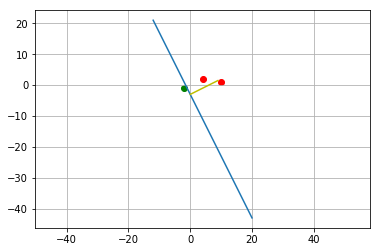

0.0
10.73312629199899
5.813776741499453
-0.8944271909999159


In [17]:
b = np.array([2, 1])
b0 = 3


def plot_data(b, b0, X, y):

    #bo + b1x1 + b2x2 = 0 => x2 = -b1/b2*x1 - b0/b2 
    x1 = np.linspace(np.min(X[:,0]) - 10, np.max(X[:,0]) + 10, 1000)
    plt.plot(x1, -b[0]/b[1]*x1 -b0/b[1])
    
    b10 = b / np.linalg.norm(b) * 10
    plt.plot([0, b10[0]], [-b0/b[1], b10[1]-b0/b[1]], c='y')
    
    for i in range(len(X)):
        plt.scatter(X[i][0], X[i][1], c=('r' if y[i] == 1 else 'g'))

    plt.axis('equal')
    plt.grid()
    plt.show()

X = np.array([
    [10, 1],
    [4, 2],
    [-2, -1]
])
y = np.array([
    1,
    1,
    -1
])

plot_data(b, b0, X, y)


preds = np.sign(X @ b + b0)
print(metrics.tdist(preds, y))

def sep_dist(x):
    return (x @ b + b0) / np.linalg.norm(b)

for i in range(len(X)):
    print(sep_dist(X[i]))

epoch -1: loss = 0
epoch 0: loss = 0


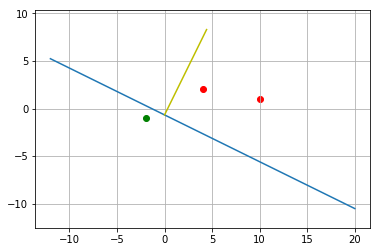

In [23]:


def perceptron(X, y, lr, nepochs):
    b = np.random.randn(2)
    b0 = np.random.randn()
    
    def get_loss():
        loss = 0
        for i in range(len(X)):
            v = X[i] @ b + b0
            if np.sign(v) != y[i]:
                loss -= y[i] * v
        return loss
    
    print('epoch -1: loss = {}'.format(get_loss()))
    
    for epoch in range(nepochs):
        
        for i in range(len(X)):
            v = X[i] @ b + b0
            if np.sign(v) != y[i]:
                b += lr * y[i] * X[i]
                b0 += lr * y[i]
        
        
        
        print('epoch {}: loss = {}'.format(epoch, get_loss()))
        break
        
        
    return b, b0

b, b0 = perceptron(X, y, 1, 10)
plot_data(b, b0, X, y)

## Optimal Separating Hyperplanes

An optimal separating hyperplane separates correctly the 2 classes and maximizes the distance between the hyperplane and the closest point

$$\max_{\beta, \beta_0} M$$
$$\text{subject to } \frac{1}{||\beta||} y_i(x_i^T\beta + \beta_0) \geq M, i=1,\text{...},N$$

- $M$ is the minimum distance between the hyperplane and every point of $X$.
- $\frac{1}{||\beta||} y_i(x_i^T\beta + \beta_0)$ is the distance between $x_i$ and the hyperplane. It's possitive if correctly classified, negative  otherwhise
- Let's fix $||\beta|| = \frac{1}{M}$. The problem becames:  

$$\min_{\beta, \beta_0} \frac{1}{2} ||\beta||^2$$
$$\text{subject to } y_i(x_i^T\beta + \beta_0) \geq 1, i=1,\text{...},N$$  

Using the Lagrangian, the problem is turned into an unconstrained one:
$$L_P(\beta, \beta_0, \alpha) = \frac{1}{2} ||\beta||^2 - \sum_{i=1}^N \alpha_i [y_i(x_i^T\beta + \beta_0) - 1]$$
$$\min_{\beta, \beta_0} \max_{\alpha, \alpha_i \geq 0} L_P(\beta, \beta_0, \alpha)$$

Instead of solving the primal, we solve the dual, that gaves the same result:

$$\min_{\beta, \beta_0} \max_{\alpha, \alpha_i \geq 0} L_P(\beta, \beta_0, \alpha) = \max_{\alpha, \alpha_i \geq 0} \min_{\beta, \beta_0} L_P(\beta, \beta_0, \alpha)$$ 

The solution of the primal $\min_{\beta, \beta_0} \max_{\alpha, \alpha_i \geq 0} L_P(\beta, \beta_0, \alpha)$ is the same than the solution of the dual $\max_{\alpha, \alpha_i \geq 0} \min_{\beta, \beta_0} L_P(\beta, \beta_0, \alpha)$ because the KKT conditions are satisfied.  

Solving $\frac{\partial L_P(\beta, \beta_0, \alpha)}{\partial \beta} = 0$, we get:
$$\beta = \sum_{i=1}^N \alpha_i y_i x_i$$
Solving $\frac{\partial L_P(\beta, \beta_0, \alpha)}{\partial \beta_0} = 0$, we get:
$$\sum_{i=1}^N \alpha_i y_i = 0$$


Remplacing on the original equation, we get:

$$L_D(\alpha) = \sum_{i=1}^N\alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^N \alpha_i \alpha_k y_i y_k x_i^Tx_k$$

The problem became:
$$\max_{\alpha} L_D(\alpha)$$
$$\text{s.t. } \alpha_i \geq 0 \space i=1,\text{...}, N$$
$$\text{s.t. } \sum_{i=1}^N \alpha_i y_i = 0$$

Another condition is satisfied:
    
$$\alpha_i[y_i(x_i^T\beta + \beta_0) - 1] = 0 \space i = 1,\text{...},N$$

- $\alpha_i > 0$: $y_i(x_i^T\beta + \beta_0) = 1$, which means $x_i$ is on the boundary of the slab
- $\alpha_i =0$:  $y_i(x_i^T\beta + \beta_0) > 1$, which means $x_i$ is outside of the slab

$\beta$ is defined in terms of a linear combination of the support points $x_i$ (where $\alpha_i > 0$).  
$\beta_0$ is obtained by solving $y_i(x_i^T + \beta_0) = 1$ for any support points.

Predictions are made using:
$$\hat{G}(x) = \text{sign}(x^T\hat{\beta} + \hat{\beta_0})$$

We now convert the problem into a standard quadradic programming problem:
    
Let $H \in \mathbb{R}^{N*N}$: $H_{ij} = y_i y_j x_i^Tx_j$

The problem became:
$$\max_{\alpha} 1^T\alpha - \frac{1}{2} \alpha^TH\alpha$$
$$\text{s.t. } \alpha_i \geq 0$$
$$\text{s.t. } y^T \alpha = 0$$

We reverse the sign and turn it into a minimization:

$$\min_{\alpha} \frac{1}{2} \alpha^TH\alpha - 1^T\alpha$$
$$\text{s.t. } - \alpha_i \leq 0$$
$$\text{s.t. } y^T \alpha = 0$$

We can compute the parameters:

$$\beta = (y \odot \alpha) X$$
$$\beta_0 = y_i - x_i \beta, \space \forall i: \alpha_i > 0$$

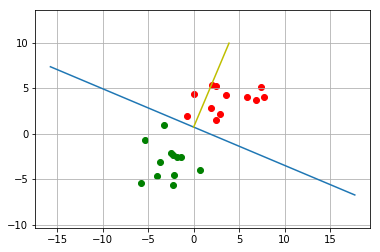

In [128]:
np.random.seed(18)

N = 25
P = 2
X1 = np.random.randn(int(N/2), P) * 2 - 3.4
X2 = np.random.randn(int(N/2), P) * (-2) + 4.2
X = np.concatenate((X1, X2), axis=0)
rb = np.random.randn(P)
rb0 = np.random.randn()
y = np.sign(X @ rb + rb0)
plot_data(rb, rb0, X, y)

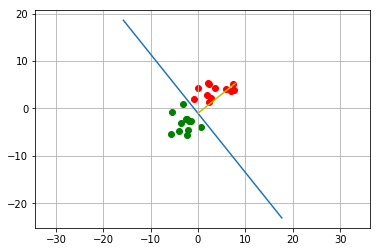

In [129]:
def svm_hard(X, y):
    n, p = X.shape
    X = X.astype(np.double)
    y = y.astype(np.double)
    
    H = (y.reshape(-1, 1)*X @ (y.reshape(-1, 1)*X).T)
    
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-np.ones((n, 1)))
    G = cvxopt.matrix(-np.eye(n))
    h = cvxopt.matrix(np.zeros((n,)))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros((1,)))
    
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.array(sol['x']).flatten()
    
    beta = (y * alpha) @ X
    S = (alpha > 1e-4)
    beta0 = y[S] - (X[S] @ beta)
    beta0 = np.mean(beta0)
    
    return alpha, beta, beta0
    
alpha, beta, beta0 = svm_hard(X, y)
plot_data(beta, beta0, X, y)

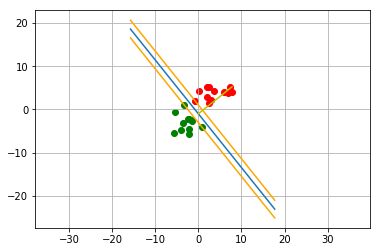

In [130]:
def plot_data_support(b, b0, X, y):

    #bo + b1x1 + b2x2 = 0 => x2 = -b1/b2*x1 - b0/b2 
    x1 = np.linspace(np.min(X[:,0]) - 10, np.max(X[:,0]) + 10, 1000)
    plt.plot(x1, -b[0]/b[1]*x1 -b0/b[1])
    plt.plot(x1, (1 - b0 - b[0] * x1)/b[1], c='orange')
    plt.plot(x1, (-1 - b0 - b[0] * x1)/b[1], c='orange')
            
    b10 = b / np.linalg.norm(b) * 10
    plt.plot([0, b10[0]], [-b0/b[1], b10[1]-b0/b[1]], c='y')
    
    for i in range(len(X)):
        plt.scatter(X[i][0], X[i][1], c=('r' if y[i] == 1 else 'g'))

    plt.axis('equal')
    plt.grid()
    plt.show()
    
plot_data_support(beta, beta0, X, y)

In [131]:
S = (alpha > 1e-4)
S_idxs = np.arange(len(X))[S]
S_vecs = X[S_idxs]
S_nc = np.array([
    np.sum(y[S_idxs] == -1),
    np.sum(y[S_idxs] == +1),
])

y_pred = np.sign(X @ beta + beta0)
acc = np.average(y == y_pred)

print('beta:', beta)
print('beta_0:', beta0)
print('Indices of support vectors:', S_idxs)
print('Support vectors:', S_vecs)
print('Number of support vectors for each class:', S_nc)
print('Accuracy:', acc)

beta: [0.60863972 0.48769628]
beta_0: 0.4945487191858977
Indices of support vectors: [ 0  9 15]
Support vectors: [[-3.24114311  0.98040471]
 [ 0.73409373 -3.98064823]
 [-0.72740321  1.94419727]]
Number of support vectors for each class: [2 1]
Accuracy: 1.0


In [132]:
#Comparing with sklearn

from sklearn.svm import SVC
clf = SVC(C = 1e10, kernel = 'linear')
clf.fit(X, y)

y_pred = clf.predict(X)
acc = np.average(y == y_pred)

print('beta:', clf.coef_)
print('beta_0:', clf.intercept_)
print('Indices of support vectors:', clf.support_)
print('Support vectors:', clf.support_vectors_)
print('Number of support vectors for each class:', clf.n_support_)
print('Accuracy:', acc)

beta: [[0.60842821 0.48764409]]
beta_0: [0.49430228]
Indices of support vectors: [ 0  9 15]
Support vectors: [[-3.24114311  0.98040471]
 [ 0.73409373 -3.98064823]
 [-0.72740321  1.94419727]]
Number of support vectors for each class: [2 1]
Accuracy: 1.0
